In [ ]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP PROJECT/Sarcasm Detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [ ]:
data.shape

(28619, 3)

In [ ]:
data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [ ]:
data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [ ]:
data.duplicated().sum()

2

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.is_sarcastic.value_counts()

0    14984
1    13633
Name: is_sarcastic, dtype: int64

In [ ]:
data.dtypes

is_sarcastic     int64
headline        object
article_link    object
dtype: object

In [ ]:
data.drop(columns=['article_link'], inplace=True)

In [ ]:
data["headline"] = data["headline"].str.lower()
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [ ]:
# Removing the punctuations from the data

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

data["headline"] = data["headline"].apply(lambda text: remove_punctuation(text))
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,0,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word stream...


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Removing the Stop words from the data

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["headline"] = data["headline"].apply(lambda text: remove_stopwords(text))
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


In [ ]:
cnt = Counter()
for text in data["headline"].values:
    for word in text.split():
        cnt[word] += 1

cnt.most_common(10)

[('new', 1677),
 ('trump', 1389),
 ('man', 1373),
 ('report', 604),
 ('us', 601),
 ('one', 555),
 ('woman', 505),
 ('area', 494),
 ('says', 485),
 ('day', 475)]

In [ ]:
# Remvoe the Frequent used words

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data["headline"] = data["headline"].apply(lambda text: remove_freqwords(text))
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


In [ ]:
# Remove rarely occuring words from data

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

data["headline"] = data["headline"].apply(lambda text: remove_rarewords(text))
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


In [ ]:
# Extra custom preprocessing

def preprocess_signs(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    return text

data['headline'] = data['headline'].apply(preprocess_signs)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


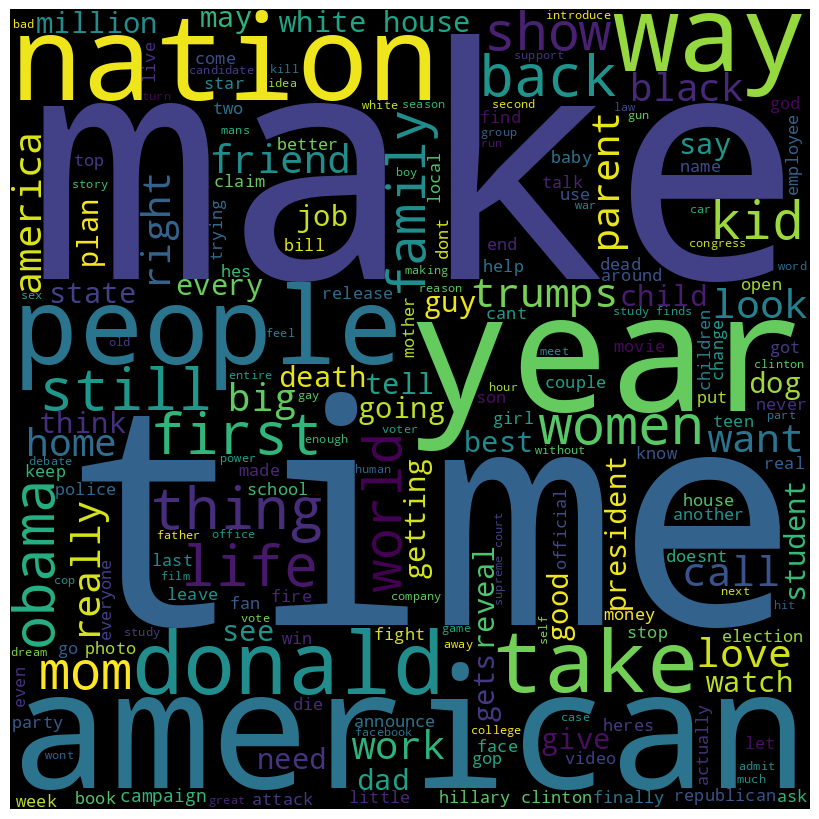

In [ ]:
# Plotting the Word Cloud

data_ = " ".join(data["headline"])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(data_)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

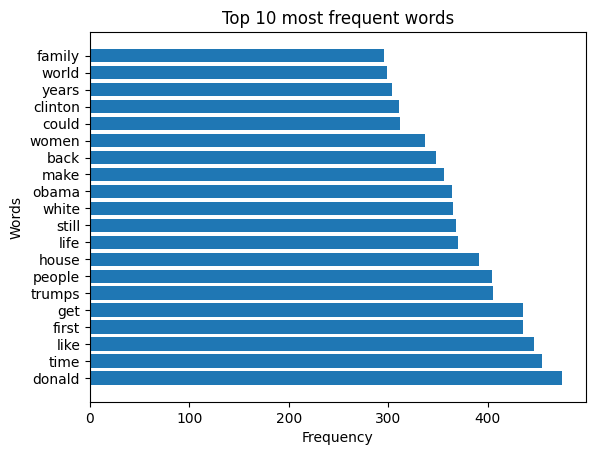

In [ ]:
# Plotting Barchart

# Concatenate all text data into a single string
text = ' '.join(data['headline'].tolist())

# Convert the text data to a dictionary of word frequencies
word_counts = {}
for word in text.split():
    if word not in word_counts:
        word_counts[word] = 0
    word_counts[word] += 1

# Get the top 10 most frequent words
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]

# Create a bar chart using matplotlib
plt.barh([word[0] for word in top_words], [word[1] for word in top_words])

plt.title('Top 10 most frequent words')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.show()

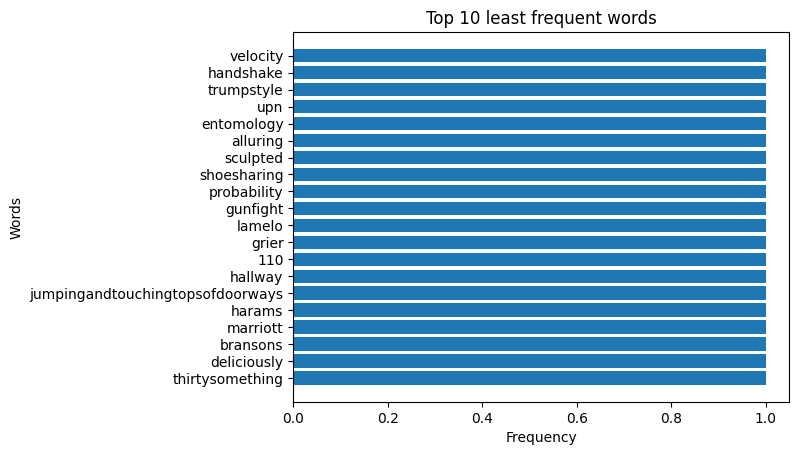

In [ ]:
# Plotting Barchart

# Convert the text data to a dictionary of word frequencies
word_counts = {}
for word in text.split():
    if word not in word_counts:
        word_counts[word] = 0
    word_counts[word] += 1

# Get the top 10 least frequent words
least_frequent_words = sorted(word_counts.items(), key=lambda x: x[1])[:20]

# Create a bar chart using Matplotlib
plt.barh([word[0] for word in least_frequent_words], [word[1] for word in least_frequent_words])

plt.title('Top 10 least frequent words')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.show()

In [ ]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import ngrams,bigrams,trigrams

In [ ]:
def cv_tf_train_test(data,vectorizer,ngram):

    # Split the data into X and y data sets
    X = data['headline']
    y = data['is_sarcastic']

    # Split our data into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Using vectorizer and removing stopwords
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')

    # Transforming x-train and x-test
    X_train_cv1 = cv1.fit_transform(X_train)
    X_test_cv1  = cv1.transform(X_test)

    ## Machine learning models

    ## Logistic regression
    lr = LogisticRegression(penalty="l2",C=2.5)
    lr.fit(X_train_cv1, y_train)
    lr_train = lr.score(X_train_cv1,y_train)
    lr_test = lr.score(X_test_cv1,y_test)

    ## k-nearest neighbours
    knn = KNeighborsClassifier(n_neighbors=20)
    knn.fit(X_train_cv1, y_train)
    knn_train = knn.score(X_train_cv1,y_train)
    knn_test = knn.score(X_test_cv1,y_test)

    ## Naive Bayes
    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    bnb_train = bnb.score(X_train_cv1,y_train)
    bnb_test = bnb.score(X_test_cv1,y_test)

    ## Multinomial naive bayes
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    mnb_train = mnb.score(X_train_cv1,y_train)
    mnb_test = mnb.score(X_test_cv1,y_test)

    ## Support vector machine
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)
    svm_train = svm_model.score(X_train_cv1,y_train)
    svm_test = svm_model.score(X_test_cv1,y_test)

    ## Random Forest
    randomforest = RandomForestClassifier(n_estimators=100, random_state=50)
    randomforest.fit(X_train_cv1, y_train)
    randomforest_train = randomforest.score(X_train_cv1,y_train)
    randomforest_test = randomforest.score(X_test_cv1,y_test)

    # ID3 Classifier
    id3_model = DecisionTreeClassifier(criterion="entropy",max_depth=9)
    id3_model.fit(X_train_cv1,y_train)
    id3_train = id3_model.score(X_train_cv1,y_train)
    id3_test = id3_model.score(X_test_cv1,y_test)

    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test),
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test),
                                f1_score(id3_model.predict(X_test_cv1), y_test)]}

    train_accuracy = {'Train Accuracy':[lr_train, knn_train, bnb_train, mnb_train, svm_train, randomforest_train, id3_train],
                      'Test Accuracy':[lr_test, knn_test, bnb_test, mnb_test, svm_test, randomforest_test, id3_test]}
    ## Saving f1 score results into a dataframe
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest','ID3 Classifier'])
    df_accuracy = pd.DataFrame(train_accuracy, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest','ID3 Classifier'])

    return df_f1,df_accuracy

In [ ]:
df_f1,df_accuracy = cv_tf_train_test(data, TfidfVectorizer, (1,1))
df_f1.rename(columns={'F1 Score': 'F1 Score(Sarcasm)'}, inplace=True)
df_accuracy.rename(columns={'Accuracy': 'Accuracy(Sarcasm)'}, inplace=True)
df_f1
# SVM has higher F1 score

,F1 Score(Sarcasm)
Log Regression,0.789015
KNN,0.557621
BernoulliNB,0.779734
MultinomialNB,0.776503
SVM,0.780733
Random Forest,0.730650
ID3 Classifier,0.121441


In [ ]:
df_accuracy

,Train Accuracy,Test Accuracy
Log Regression,0.933692,0.801363
KNN,0.722098,0.688155
BernoulliNB,0.913685,0.803284
MultinomialNB,0.910453,0.799266
SVM,0.974927,0.794025
Random Forest,0.999869,0.756813
ID3 Classifier,0.552702,0.552586


In [ ]:
# Calculating Confusion Matrix and Displaying it
X = data['headline']
y = data['is_sarcastic']

# Split our data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using vectorizer and removing stopwords
cv1 = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

# Transforming x-train and x-test
X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

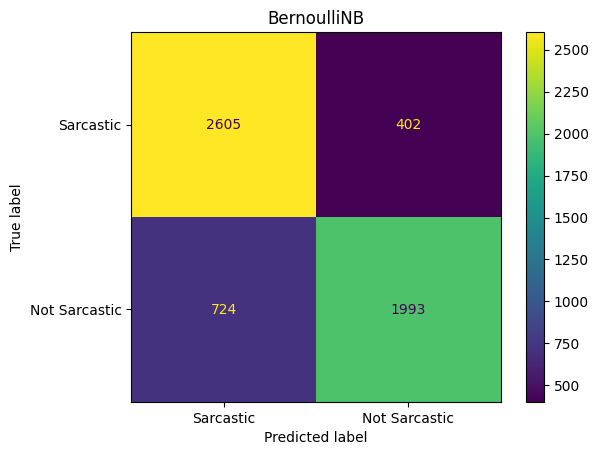

In [ ]:
bnb = BernoulliNB()
bnb.fit(X_train_cv1, y_train)
y_pred = bnb.predict(X_test_cv1)

cm = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix:", cm)

# Plotting the Confusion Matrix for Passive Aggressive
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sarcastic", "Not Sarcastic"])
disp.plot()
plt.title("BernoulliNB")
plt.show()

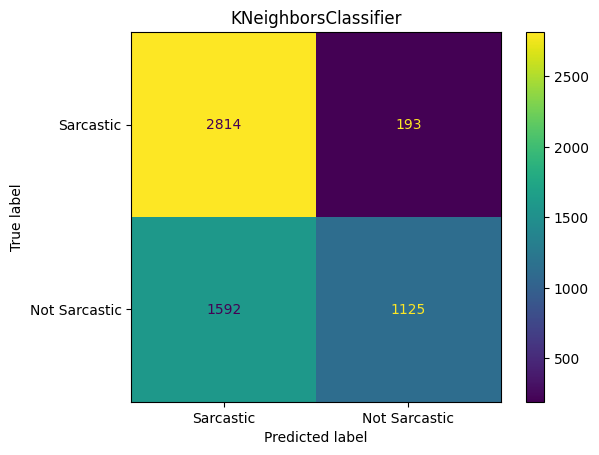

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_cv1, y_train)
y_pred = knn.predict(X_test_cv1)

cm = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix:", cm)

# Plotting the Confusion Matrix for Passive Aggressive
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sarcastic", "Not Sarcastic"])
disp.plot()
plt.title("KNeighborsClassifier")
plt.show()

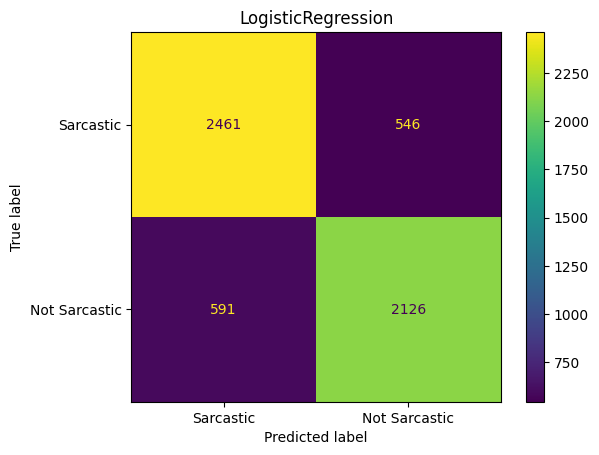

In [ ]:
lr = LogisticRegression(penalty="l2",C=2.5)
lr.fit(X_train_cv1, y_train)
y_pred = lr.predict(X_test_cv1)

cm = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix:", cm)

# Plotting the Confusion Matrix for Passive Aggressive
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sarcastic", "Not Sarcastic"])
disp.plot()
plt.title("LogisticRegression")
plt.show()

Best Performing Model

In [ ]:
svm_model = LinearSVC()
clf = svm_model.fit(X_train_cv1, y_train)
y_pred = svm_model.predict(X_test_cv1)

cm = confusion_matrix(y_test, y_pred)
#print("Confusion Matrix:", cm)

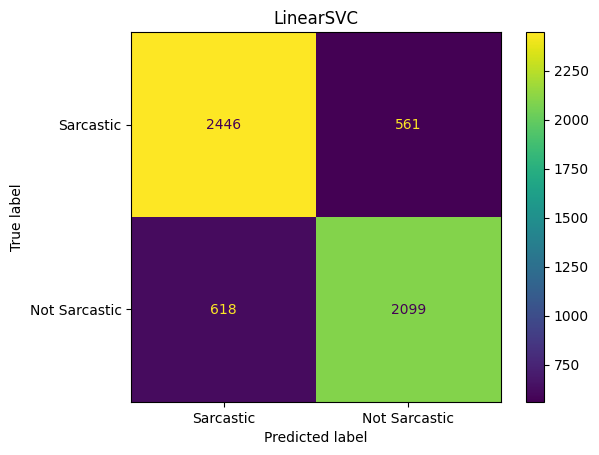

In [ ]:
# Plotting the Confusion Matrix for Passive Aggressive
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sarcastic", "Not Sarcastic"])
disp.plot()
plt.title("LinearSVC")
plt.show()

In [ ]:
# Generate the classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      3007
           1       0.79      0.77      0.78      2717

    accuracy                           0.79      5724
   macro avg       0.79      0.79      0.79      5724
weighted avg       0.79      0.79      0.79      5724



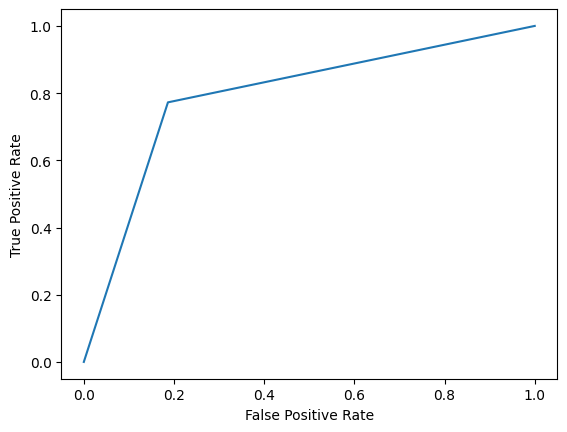

In [ ]:
# Plotting ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

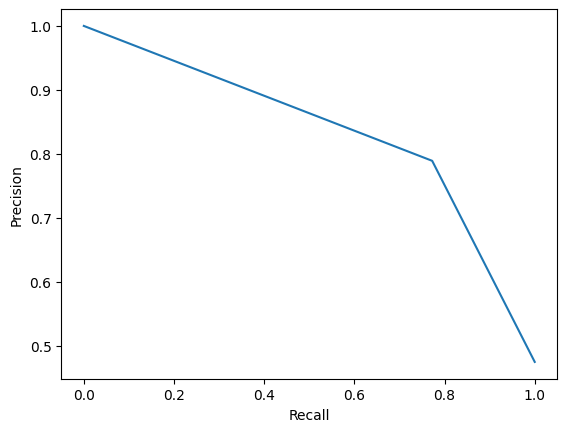

In [ ]:
# plotting Precision Recall Curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()